In [1]:
import torch
import numpy as np
from datasets import FHB_Dataset, normHSI
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import pandas as pd

def output_csv(model, filename, feature_selection=None):
    path = 'beyond-visible-spectrum-ai-for-agriculture-2024/ICPR01/kaggle/evaluation'
    data_list = os.listdir(path)

    iter_list = range(101) if not feature_selection else feature_selection
    specs = []
    for f in data_list:
        data = torch.load(os.path.join(path, f))
        data = normHSI(data)
        spec = []
        for i in iter_list:
            mean = torch.mean(data[i,:,:])
            spec.append(mean.item())
        spec.append(f)
        specs.append(spec)
    df_eval = pd.DataFrame(specs, columns=[*iter_list, 'fn'])
    x = df_eval.drop('fn', axis=1)
    fn = df_eval['fn']
    # print(fn)

    if not os.path.exists('results'):
        os.makedirs('results')

    pred = model.predict(x)
    cls_pred = [2 if x > 0.5 else 1 for x in pred] 

    df_eval = pd.DataFrame({'Id': [], 'Category': [],})
    df_eval['Id'] = fn
    df_eval['Category'] = cls_pred

    df_eval.to_csv(f'results/{filename}.csv', index=False)

In [2]:
dataset = FHB_Dataset(data_dir="beyond-visible-spectrum-ai-for-agriculture-2024/ICPR01/kaggle", transform=None, noisy=False, rotate=False)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [37]:

spec_data = []
for data in dataloader:
    img, label = data
    org_img = img.squeeze(0)
    img = normHSI(img).squeeze(0)
    spec = []
    for i in range(img.shape[0]):
        mean = torch.mean(img[i,:,:])
        spec.append(mean.item())
    spec.append(label.item())
    spec_data.append(spec)

df = pd.DataFrame(spec_data, columns=[*range(101), 'label']) # Spectral Averaging Data

/Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/datasets.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load(pa

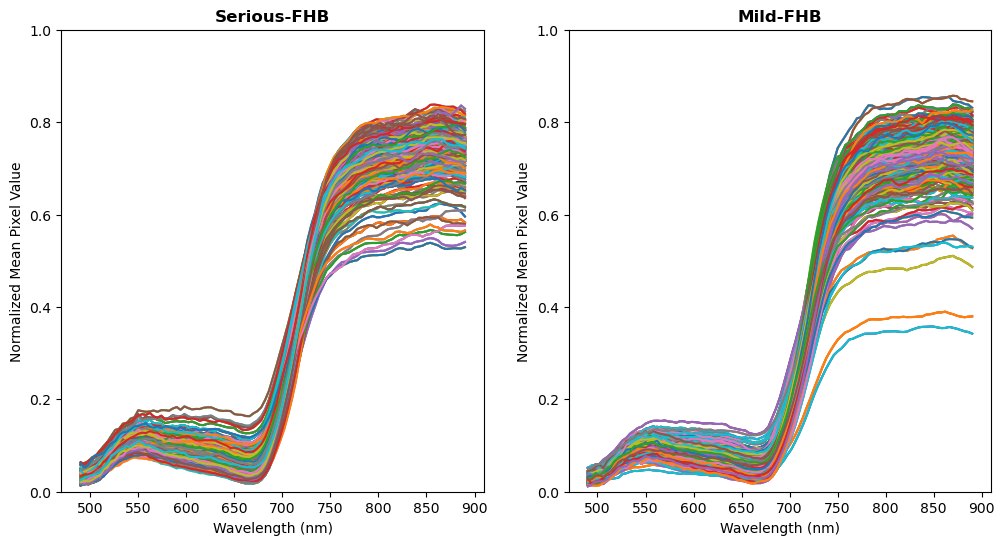

In [39]:
ymin, ymax = 0, 1

plt.figure(figsize=(12,6))

df_d = df[df['label']==1].drop('label', axis=1)
df_nd = df[df['label']==0].drop('label', axis=1)

ax = plt.subplot(1,2,1)
for i in range(df_d.shape[0]):
    ax.plot(range(490, 894, 4), df_d.iloc[i])
ax.set_ylim([ymin, ymax])
ax.set_title('Serious-FHB', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Wavelength (nm)')

ax = plt.subplot(1,2,2)
for i in range(df_nd.shape[0]):
    ax.plot(range(490, 894, 4), df_nd.iloc[i])
ax.set_ylim([ymin, ymax])
ax.set_title('Mild-FHB', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Wavelength (nm)')

plt.show()


## K-means Clustering to Get Pseudo Labels ##

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [7]:
X = df.drop('label', axis=1)  
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# reduce dimension
# pca = PCA(n_components=.2)  # 保留95%的方差
# X_reduced = pca.fit_transform(X)

# clustering 
n_clusters = 2 
kmeans = KMeans(n_clusters=n_clusters, random_state=123)
pseudo_labels = kmeans.fit_predict(X)

print(pseudo_labels.shape)

(1696,)


## LightGBM for Obtaining Importance Features Based on Pseudo Label ##


In [35]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df.drop('label', axis=1)  
y = df['label']               

# y labels are pseudo labels
X_train, X_test, y_train, y_test = train_test_split(X, pseudo_labels, test_size=0.1, random_state=123)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss', 
    'boosting': 'gbdt',  
    'num_leaves': 30,    
    'learning_rate': 0.015, 
    'verbose': -1
}

model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=300)

y_pred = model.predict(X_test)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]  
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

output_csv(model, 'lightgbm_specinfo')

Accuracy: 1.00


/var/folders/kw/577hs3157mv5cg3xrmnf7crm0000gn/T/ipykernel_38736/1110567613.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(path, f))


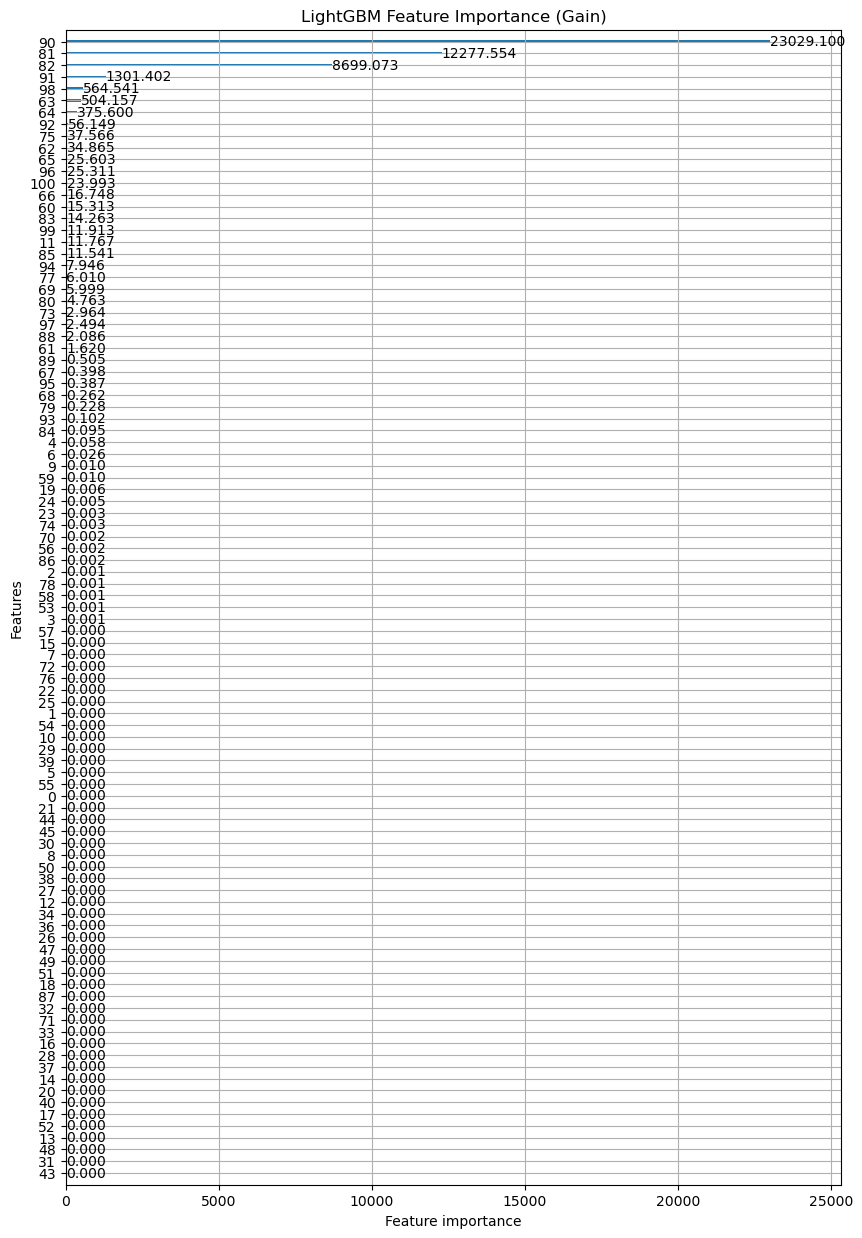

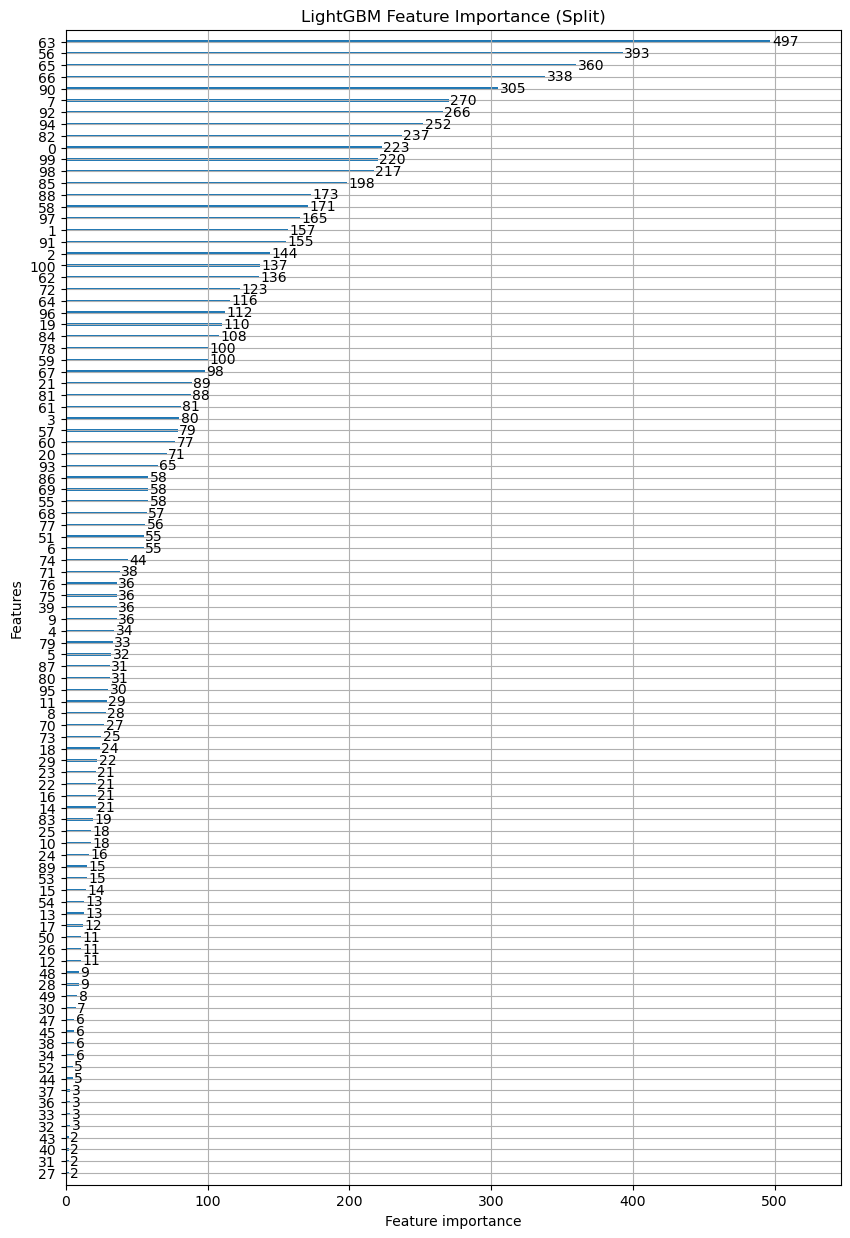

In [10]:
lgb.plot_importance(model, importance_type="gain", figsize=(10,15), title="LightGBM Feature Importance (Gain)")
plt.show()
lgb.plot_importance(model, importance_type="split", figsize=(10,15), title="LightGBM Feature Importance (Split)")
plt.show()

## K Bands Selection Strategy ##

In [12]:
gain_importance = model.feature_importance(importance_type='gain')

gain_importance_df = pd.DataFrame({'Band No.':  range(101), 'Gain': gain_importance})
print(gain_importance_df.sort_values(by='Gain', ascending=False))

    Band No.          Gain
90        90  2.302910e+04
81        81  1.227755e+04
82        82  8.699073e+03
91        91  1.301402e+03
98        98  5.645415e+02
..       ...           ...
43        43  7.771564e-15
35        35  0.000000e+00
41        41  0.000000e+00
42        42  0.000000e+00
46        46  0.000000e+00

[101 rows x 2 columns]


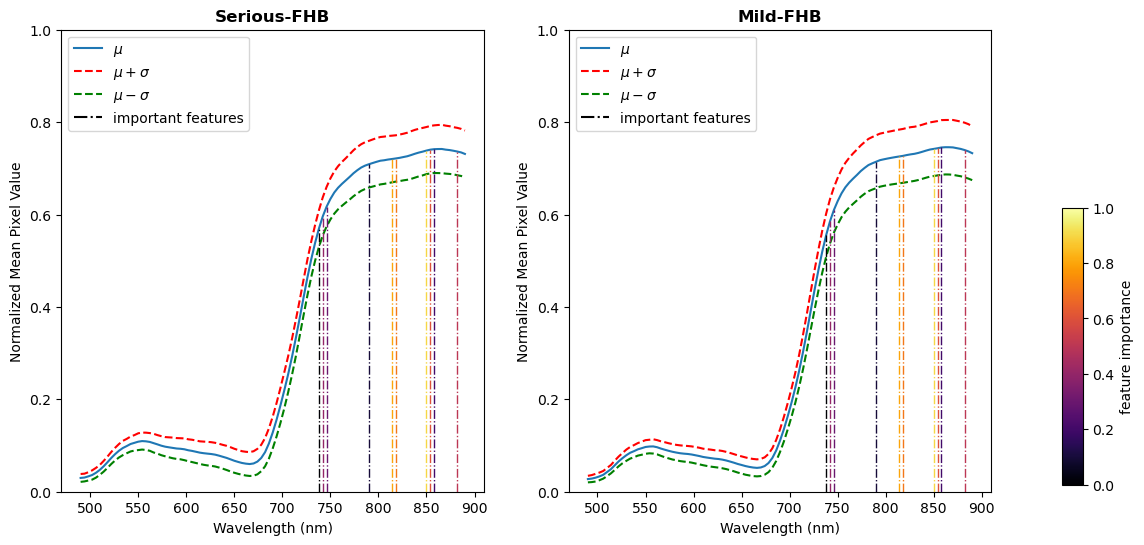

In [13]:
from operator import add, neg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

ymin, ymax = 0, 1

k = 10
plt.figure(figsize=(12,6))
mpl.rcParams.update(mpl.rcParamsDefault)

# 假設df_d和df_nd是你之前已經定義的資料框
# 並且gain_importance_df也是你之前已經定義的資料框

df_d = df[df['label']==1].drop('label', axis=1)
df_nd = df[df['label']==0].drop('label', axis=1)

mean1, mean0 = [], []
std1, std0 = [], []

# 第一張圖
ax = plt.subplot(1,2,1)
for i in range(101):
   mean1.append(df_d[i].mean())
   std1.append(df_d[i].std())
ax.plot(range(490, 894, 4), mean1, label=r'$\mu$')
ax.plot(range(490, 894, 4), list(map(add, mean1, std1)), 'r--', label=r'$\mu + \sigma$')
ax.plot(range(490, 894, 4), list(map(add, mean1, list(map(neg, std1)))), 'g--', label=r'$\mu - \sigma$')
ax.set_ylim([ymin, ymax])
ax.set_title('Serious-FHB', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Wavelength (nm)')
for i, b in enumerate(gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:k]):
   ax.axvline(b*4+490, linewidth=1, color=plt.cm.inferno((k-i-1)/k), ymax=mean1[b], linestyle='-.')

# 調整colorbar的位置到圖的右邊，避免遮擋主要圖像內容
# axins = inset_axes(plt.gca(), width="5%", height="100%", loc='center right', bbox_to_anchor=(1.15, 0, 1, 1), bbox_transform=plt.gca().transAxes)
# sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=1))
# plt.colorbar(sm, cax=axins, label='feature importance')

feaimplb = Line2D([0], [0], label='important features', color='black', linestyle='-.')
handles, labels = ax.get_legend_handles_labels()
handles.append(feaimplb) 
ax.legend(handles=handles, loc='upper left')

# 第二張圖
ax = plt.subplot(1,2,2)
for i in range(101):
   mean0.append(df_nd[i].mean())
   std0.append(df_nd[i].std())
ax.plot(range(490, 894, 4), mean0, label=r'$\mu$')
ax.plot(range(490, 894, 4), list(map(add, mean0, std0)), 'r--', label=r'$\mu + \sigma$')
ax.plot(range(490, 894, 4), list(map(add, mean0, list(map(neg, std0)))), 'g--', label=r'$\mu - \sigma$')
ax.set_ylim([ymin, ymax])
ax.set_title('Mild-FHB', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Wavelength (nm)')
for i, b in enumerate(gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:k]):
   ax.axvline(b*4+490, linewidth=1, color=plt.cm.inferno((k-i-1)/k), ymax=mean0[b], linestyle='-.')

# 調整colorbar的位置到圖的右邊，避免遮擋主要圖像內容
axins = inset_axes(plt.gca(), width="5%", height="60%", loc='lower left', bbox_to_anchor=(1.15, 0, 1, 1), bbox_transform=plt.gca().transAxes)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm, cax=axins, label='feature importance')

feaimplb = Line2D([0], [0], label='important features', color='black', linestyle='-.')
handles, labels = ax.get_legend_handles_labels()
handles.append(feaimplb) 
ax.legend(handles=handles, loc='upper left')

plt.show()

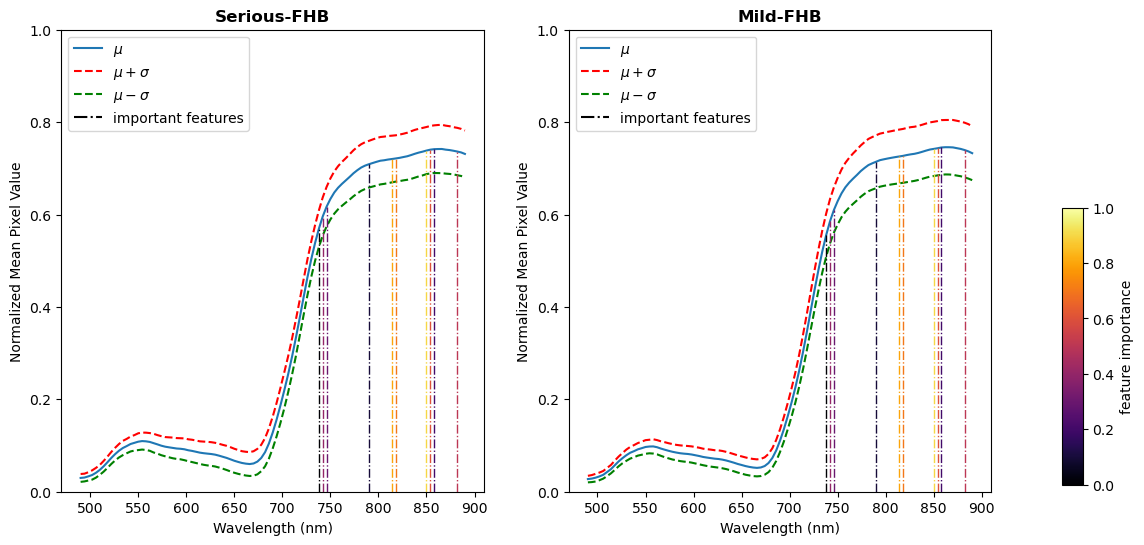

In [14]:
from operator import add, neg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

ymin, ymax = 0, 1

k = 10
plt.figure(figsize=(12,6))
mpl.rcParams.update(mpl.rcParamsDefault)

# 假設df_d和df_nd是你之前已經定義的資料框
# 並且gain_importance_df也是你之前已經定義的資料框

df_d = df[df['label']==1].drop('label', axis=1)
df_nd = df[df['label']==0].drop('label', axis=1)

mean1, mean0 = [], []
std1, std0 = [], []

# 第一張圖
ax = plt.subplot(1,2,1)
for i in range(101):
   mean1.append(df_d[i].mean())
   std1.append(df_d[i].std())
ax.plot(range(490, 894, 4), mean1, label=r'$\mu$')
ax.plot(range(490, 894, 4), list(map(add, mean1, std1)), 'r--', label=r'$\mu + \sigma$')
ax.plot(range(490, 894, 4), list(map(add, mean1, list(map(neg, std1)))), 'g--', label=r'$\mu - \sigma$')
ax.set_ylim([ymin, ymax])
ax.set_title('Serious-FHB', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Wavelength (nm)')
for i, b in enumerate(gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:k]):
   ax.axvline(b*4+490, linewidth=1, color=plt.cm.inferno((k-i-1)/k), ymax=mean1[b], linestyle='-.')

# 調整colorbar的位置到圖的右邊，避免遮擋主要圖像內容
# axins = inset_axes(plt.gca(), width="5%", height="100%", loc='center right', bbox_to_anchor=(1.15, 0, 1, 1), bbox_transform=plt.gca().transAxes)
# sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=1))
# plt.colorbar(sm, cax=axins, label='feature importance')

feaimplb = Line2D([0], [0], label='important features', color='black', linestyle='-.')
handles, labels = ax.get_legend_handles_labels()
handles.append(feaimplb) 
ax.legend(handles=handles, loc='upper left')

# 第二張圖
ax = plt.subplot(1,2,2)
for i in range(101):
   mean0.append(df_nd[i].mean())
   std0.append(df_nd[i].std())
ax.plot(range(490, 894, 4), mean0, label=r'$\mu$')
ax.plot(range(490, 894, 4), list(map(add, mean0, std0)), 'r--', label=r'$\mu + \sigma$')
ax.plot(range(490, 894, 4), list(map(add, mean0, list(map(neg, std0)))), 'g--', label=r'$\mu - \sigma$')
ax.set_ylim([ymin, ymax])
ax.set_title('Mild-FHB', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Wavelength (nm)')
for i, b in enumerate(gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:k]):
   ax.axvline(b*4+490, linewidth=1, color=plt.cm.inferno((k-i-1)/k), ymax=mean0[b], linestyle='-.')

# 調整colorbar的位置到圖的右邊，避免遮擋主要圖像內容
axins = inset_axes(plt.gca(), width="5%", height="60%", loc='lower left', bbox_to_anchor=(1.15, 0, 1, 1), bbox_transform=plt.gca().transAxes)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm, cax=axins, label='feature importance')

feaimplb = Line2D([0], [0], label='important features', color='black', linestyle='-.')
handles, labels = ax.get_legend_handles_labels()
handles.append(feaimplb) 
ax.legend(handles=handles, loc='upper left')

plt.show()

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
## we also use SVM to validate the k bands selection performance

def train_kfeas_lgb(k, df, output_result=False):            
    X2 = df.drop('label', axis=1)[gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:k]]
    y2 = df['label']    

    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, random_state=123)

    train_data2 = lgb.Dataset(X_train2, label=y_train2)
    test_data2 = lgb.Dataset(X_test2, label=y_test2)

    params2 = {
        'objective': 'binary',  
        'metric': 'binary_logloss', 
        'boosting': 'gbdt',  
        'num_leaves': 30,    
        'learning_rate': 0.015,
        'verbose': -1
    }

    model2 = lgb.train(params2, train_data2, valid_sets=[test_data2], num_boost_round=300)

    y_pred2 = model2.predict(X_test2)
    y_pred_binary2 = [1 if x > 0.5 else 0 for x in y_pred2] 
    accuracy2 = accuracy_score(y_test2, y_pred_binary2)

    if output_result:
        output_csv(model2, f'lightGBM_{k}_bands', feature_selection=X2.columns.to_list())

    return accuracy2

def train_kfeas_svm(k, df, output_result=False):
    X2 = df.drop('label', axis=1)[gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:k]]
    y2 = df['label']                

    X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.1, random_state=123)

    clf = make_pipeline(StandardScaler(), SVC(kernel='rbf',gamma=0.75,C=5.0))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc_svm = accuracy_score(y_test, y_pred)

    if output_result:
        output_csv(clf, f'SVM_{k}_bands', feature_selection=X2.columns.to_list())

    return acc_svm

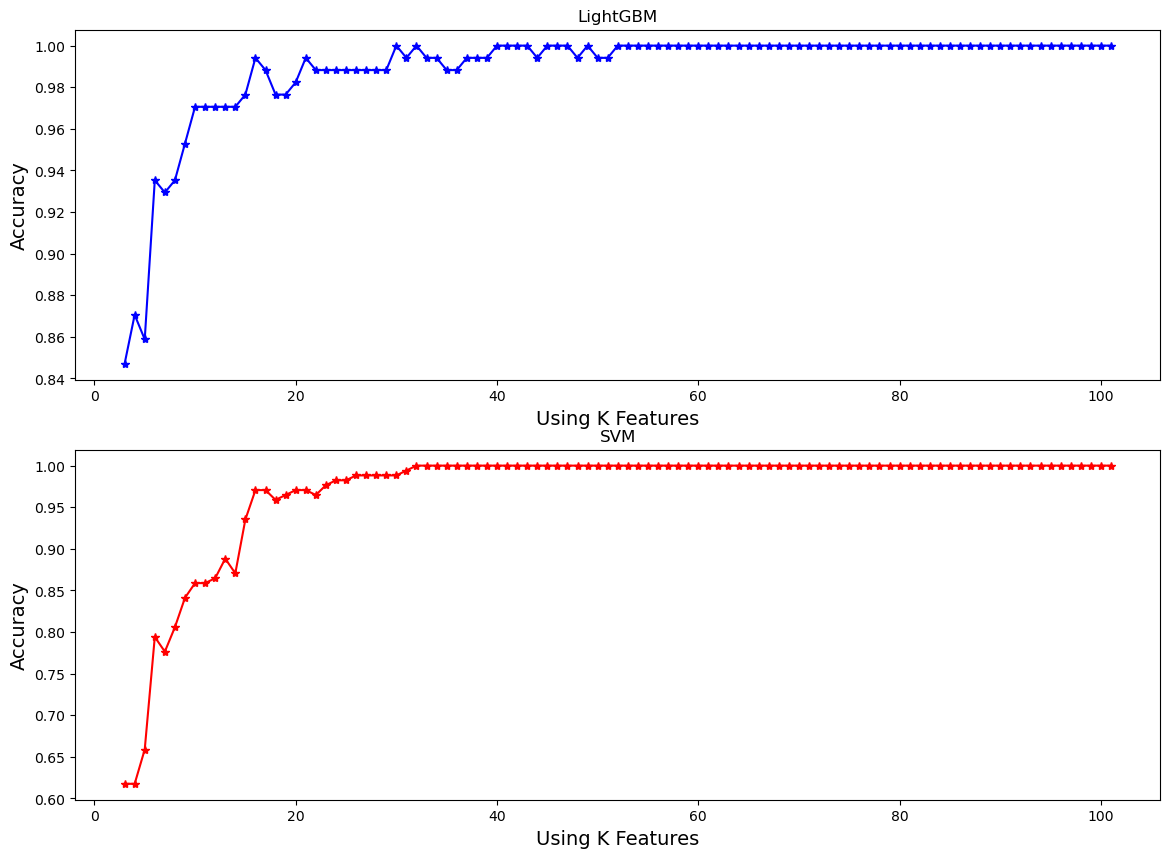

In [16]:
resultK1, resultK2 = [], []
resultAcc1, resultAcc2 = [], []

for k in range(3,101+1,1):
    acc = train_kfeas_lgb(k, df)
    resultK1.append(k)
    resultAcc1.append(acc)
for k in range(3,101+1,1):
    acc = train_kfeas_svm(k, df)
    resultK2.append(k)
    resultAcc2.append(acc)

plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
plt.plot(resultK1, resultAcc1, 'b*-')
plt.xlabel('Using K Features', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('LightGBM')
# plt.xticks(resultK1)
plt.subplot(2,1,2)
plt.plot(resultK2, resultAcc2, 'r*-')
plt.xlabel('Using K Features', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('SVM')
# plt.xticks(resultK2)
plt.show()

## Predict (use 30 bands)

In [18]:
lgb_30_bands_acc = train_kfeas_lgb(k=30, df=df, output_result=True)
svm_30_bands_acc = train_kfeas_svm(k=30, df=df, output_result=True)
print(f'LightGBM 30 bands prediction accuracy: {lgb_30_bands_acc:.4f}')
print(f'SVM 30 bands prediction accuracy: {svm_30_bands_acc:.4f}')

LightGBM 30 bands prediction accuracy: 1.0000
SVM 30 bands prediction accuracy: 0.9882


/var/folders/kw/577hs3157mv5cg3xrmnf7crm0000gn/T/ipykernel_38736/1110567613.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(path, f))
/va

## NDVI Index ##

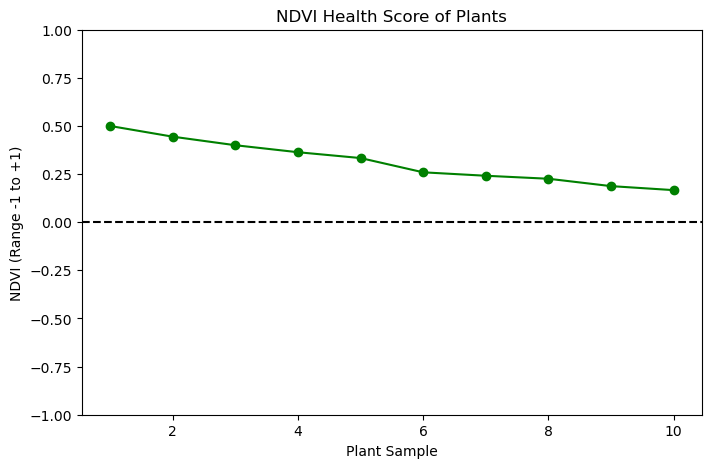

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Example: take Red and NIR bands from your hyperspectral dataset
# (here I am just making dummy data for 10 plants)
red_band = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7])
nir_band = np.array([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.95, 0.98])

# NDVI formula
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Plot NDVI values
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ndvi)+1), ndvi, marker='o', color='green')
plt.axhline(0, color='black', linestyle='--')  # reference line at 0
plt.title("NDVI Health Score of Plants")
plt.xlabel("Plant Sample")
plt.ylabel("NDVI (Range -1 to +1)")
plt.ylim(-1, 1)
plt.show()


Cube shape: (101, 32, 32)


/var/folders/kw/577hs3157mv5cg3xrmnf7crm0000gn/T/ipykernel_44551/413127687.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cube = torch.load(sample_path)   # tensor


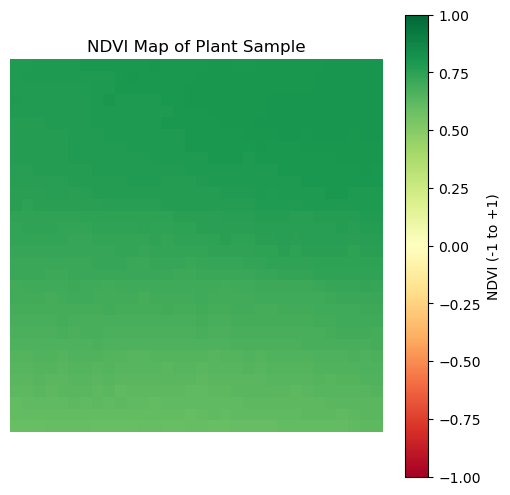

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# 1) Path where your .pt files are stored
data_dir = "beyond-visible-spectrum-ai-for-agriculture-2024/ICPR01/kaggle/evaluation"

# 2) Load one sample .pt file to inspect (you can loop over all later)
sample_file = os.listdir(data_dir)[0]   # pick first file
sample_path = os.path.join(data_dir, sample_file)

# 3) Load hyperspectral cube (shape: [bands, height, width])
cube = torch.load(sample_path)   # tensor
cube = cube.numpy()              # convert to numpy

print("Cube shape:", cube.shape) # e.g. (150 bands, H, W)

# 4) Wavelength mapping (dataset has 490nm–890nm, ~4nm steps)
wavelengths = np.arange(490, 894, 4)  # (100 values, may need check if cube has 150 bands)

# 5) Find band indices for Red (~660nm) and NIR (~800nm)
red_idx = int(np.argmin(np.abs(wavelengths - 660)))
nir_idx = int(np.argmin(np.abs(wavelengths - 800)))

# 6) Extract Red & NIR bands (2D images)
red_band = cube[red_idx, :, :].astype(float)
nir_band = cube[nir_idx, :, :].astype(float)

# 7) Compute NDVI pixel-wise
ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-8)
# 8) Plot NDVI heatmap
plt.figure(figsize=(6,6))
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar(label="NDVI (-1 to +1)")
plt.title("NDVI Map of Plant Sample")
plt.axis("off")
plt.show()